# DATA MINING - GRUPPO 2
## Diabets dataset
The aim of this project is to create a model to predict if
a patient will be readmitted or not after a specific encounter.

The first thing is to import the dataset

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import re
plt.style.use('ggplot')

df = pd.read_csv("dataset_diabetes/diabetic_data.csv", low_memory=False, delimiter=',', na_values='?')

df

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
1             149190     55629189        Caucasian  Female  [10-20)    NaN   
2              64410     86047875  AfricanAmerican  Female  [20-30)    NaN   
3             500364     82442376        Caucasian    Male  [30-40)    NaN   
4              16680     42519267        Caucasian    Male  [40-50)    NaN   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)    NaN   
101763     443854148     41088789        Caucasian    Male  [70-80)    NaN   
101764     443857166     31693671        Caucasian  Female  [80-90)    NaN   
101765     443867222    175429310        Caucasian    Male  [70-80)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

The dataset contains 101766 records with 50 columns. The columns
are:

In [2]:
print(df.columns.to_list())

['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


let's unify the '> 30' and 'no' class value

In [3]:
def unify_value(x: pd.Series) -> pd.Series:
    if x['readmitted'] == '>30':
        x['readmitted'] = 'NO'
    return x

df = df.apply(unify_value, axis=1)


Some columns contains null values, in particular

In [4]:
df.isna().apply(lambda x: f'{round((sum(x) / df.shape[0]) * 100, 1)}%')

encounter_id                 0.0%
patient_nbr                  0.0%
race                         2.2%
gender                       0.0%
age                          0.0%
weight                      96.9%
admission_type_id            0.0%
discharge_disposition_id     0.0%
admission_source_id          0.0%
time_in_hospital             0.0%
payer_code                  39.6%
medical_specialty           49.1%
num_lab_procedures           0.0%
num_procedures               0.0%
num_medications              0.0%
number_outpatient            0.0%
number_emergency             0.0%
number_inpatient             0.0%
diag_1                       0.0%
diag_2                       0.4%
diag_3                       1.4%
number_diagnoses             0.0%
max_glu_serum                0.0%
A1Cresult                    0.0%
metformin                    0.0%
repaglinide                  0.0%
nateglinide                  0.0%
chlorpropamide               0.0%
glimepiride                  0.0%
acetohexamide 

Let's check if the 2.2% of null value in race are correlated with the class
label

In [5]:
amount = df[(df['race'].isnull()) & (df['readmitted'] == '<30')].shape[0]
total = df[(df['readmitted'] == '<30')].shape[0]
percentage = ( amount / total) * 100
percentage

1.6553667341727567

There are 188 records with our target class value, so we decide to
maintain them as "not assigned"

In [6]:
df = df.drop(df[df['race'].isnull()].index)

Many of the pathologies reported in the dataset (afferent to the diag columns) are part of disease macrogroups (as indicated by documentation). Consequently, we decided to group them. Particular is the category other, which contains ranges of pathologies not very frequent in the dataset.

In [7]:
df[['diag_1', 'diag_2', 'diag_3']].fillna("Other", inplace=True)

C:\Users\oliva\anaconda3\lib\site-packages\pandas\core\frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [8]:
df['diag_1'] = df['diag_1'].astype(str)
df['diag_2'] = df['diag_2'].astype(str)
df['diag_3'] = df['diag_3'].astype(str)

def unify_disease_group(x: pd.Series) -> pd.Series:
    for i in range(1, 4):
        if not x['diag_' + str(i)].isnumeric() and re.match(r'^-?\d+(?:\.\d+)$', x['diag_' + str(i)]) is None:
            x['diag_' + str(i)] = 'Other'
        elif re.match(r'^-?\d+(?:\.\d+)$', x['diag_' + str(i)]) is not None and "250." not in x['diag_' + str(i)]:
            x['diag_' + str(i)] = 'Other'
        elif "250." in x['diag_' + str(i)]:
            x['diag_' + str(i)] = 'Diabetes'
        elif (int(x['diag_' + str(i)]) >= 390 and int(x['diag_' + str(i)]) <= 459) or int(x['diag_' + str(i)]) == 785:
                x['diag_' + str(i)] = 'Circulatory'
        elif (int(x['diag_' + str(i)]) >= 460 and int(x['diag_' + str(i)]) <= 519) or int(x['diag_' + str(i)]) == 786:
                x['diag_' + str(i)] = 'Respiratory'
        elif int(x['diag_' + str(i)]) <= 579 or int(x['diag_' + str(i)]) == 787:
            x['diag_' + str(i)] = 'Digestive'
        elif int(x['diag_' + str(i)]) >= 800 and int(x['diag_' + str(i)]) <= 999:
            x['diag_' + str(i)] = 'Injury'
        elif int(x['diag_' + str(i)]) >= 710 and int(x['diag_' + str(i)]) <= 739:
            x['diag_' + str(i)] = 'Muscoloskeletal'
        elif (int(x['diag_' + str(i)]) >= 580 and int(x['diag_' + str(i)]) <= 629) or int(x['diag_' + str(i)]) == 788:
            x['diag_' + str(i)] = 'Genitourinary'
        elif int(x['diag_' + str(i)]) >= 140 and int(x['diag_' + str(i)]) <= 239:
            x['diag_' + str(i)] = 'Neoplasm'
        else:
            x['diag_' + str(i)] = 'Other'
    return x

df = df.apply(unify_disease_group, axis=1)

df[df['diag_1'] == 'Diabetes']

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)    NaN   
10             28236     89869032  AfricanAmerican  Female  [40-50)    NaN   
52            590346     37746639  AfricanAmerican  Female  [40-50)    NaN   
56            630342     93232917  AfricanAmerican  Female  [50-60)    NaN   
60            676422     63754317  AfricanAmerican  Female  [70-80)    NaN   
...              ...          ...              ...     ...      ...    ...   
101719     443256548    162949523        Caucasian    Male  [10-20)    NaN   
101728     443710592     84391839        Caucasian  Female  [30-40)    NaN   
101742     443787512     52419276        Caucasian    Male  [70-80)    NaN   
101753     443841992    184875899            Other    Male  [40-50)    NaN   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)    NaN   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
10                      1                         1                    7   
52                      1                         6                    7   
56                      3                         6                    2   
60                      1                         1                    7   
...                   ...                       ...                  ...   
101719                  1                         7                    7   
101728                  1                         1                    7   
101742                  2                         6                    2   
101753                  1                         1                    7   
101761                  1                         3                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
10                     9  ...          No  Steady                   No   
52                     8  ...          No  Steady                   No   
56                     9  ...          No  Steady                   No   
60                     4  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101719                 1  ...          No      Up                   No   
101728                 5  ...          No      No                   No   
101742                 4  ...          No  Steady                   No   
101753                13  ...          No    Down                   No   
101761                 3  ...          No    Down                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
10                       No                        No   
52                       No                        No   
56                       No                        No   
60                       No                        No   
...                     ...                       ...   
101719                   No                        No   
101728                   No                        No   
101742                   No                        No   
101753                   No                        No   
101761                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
10                           No                      No      No         Yes   
52                           No                      No      No         Yes   
56                           No                      No      No         Yes   
60                           No                      No      No         Yes   
...                         ...                     ...     ...         ...   
101719                       No

Since "weight", "payer_code", "medical_specialty" have a high percentage of null
value, we can remove them

In [9]:
df = df.drop(columns=['weight', 'payer_code', 'medical_specialty'])

There are some ids that are equivalent, so we can unify them

In [10]:
def merge_ids(series: pd.Series) -> pd.Series:
    if series['admission_type_id'] == 5 or series['admission_type_id'] == 6:
        series['admission_type_id'] = 8
    if series['discharge_disposition_id'] == 18 or series['discharge_disposition_id'] == 26:
        series['discharge_disposition_id'] = 25
    if series['admission_source_id'] == 9 or series['admission_source_id'] == 15 or series['admission_source_id'] == 17 or series['admission_source_id'] == 21:
        series['admission_source_id'] = 20
    return series

df = df.apply(merge_ids, axis=1)

Some informations about the column type and the null values

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99493 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id              99493 non-null  int64 
 1   patient_nbr               99493 non-null  int64 
 2   race                      99493 non-null  object
 3   gender                    99493 non-null  object
 4   age                       99493 non-null  object
 5   admission_type_id         99493 non-null  int64 
 6   discharge_disposition_id  99493 non-null  int64 
 7   admission_source_id       99493 non-null  int64 
 8   time_in_hospital          99493 non-null  int64 
 9   num_lab_procedures        99493 non-null  int64 
 10  num_procedures            99493 non-null  int64 
 11  num_medications           99493 non-null  int64 
 12  number_outpatient         99493 non-null  int64 
 13  number_emergency          99493 non-null  int64 
 14  number_inpatient     

Let's fix the types

In [12]:
for attribute in df.columns:
    if df[attribute].dtype == np.object:
        df[attribute] = df[attribute].astype('category')

df['admission_type_id'] = df['admission_type_id'].astype('category')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')
df['admission_source_id'] = df['admission_source_id'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99493 entries, 0 to 101765
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              99493 non-null  int64   
 1   patient_nbr               99493 non-null  int64   
 2   race                      99493 non-null  category
 3   gender                    99493 non-null  category
 4   age                       99493 non-null  category
 5   admission_type_id         99493 non-null  category
 6   discharge_disposition_id  99493 non-null  category
 7   admission_source_id       99493 non-null  category
 8   time_in_hospital          99493 non-null  int64   
 9   num_lab_procedures        99493 non-null  int64   
 10  num_procedures            99493 non-null  int64   
 11  num_medications           99493 non-null  int64   
 12  number_outpatient         99493 non-null  int64   
 13  number_emergency          99493 non-null  int

Since there are two columns with only one possible value, we can drop them

In [13]:
df = df.drop(columns=['examide', 'citoglipton'])

We are not interested in patient number and encounter id

In [14]:
df = df.drop(columns=['encounter_id', 'patient_nbr'])

The most frequent value for the categorical attributes are:

In [15]:
info_columns = df.describe(include='category').T
info_columns

count unique          top   freq
race                      99493      5    Caucasian  76099
gender                    99493      3       Female  53575
age                       99493     10      [70-80)  25469
admission_type_id         99493      6            1  52900
discharge_disposition_id  99493     25            1  58768
admission_source_id       99493     15            7  56632
diag_1                    99493      8  Circulatory  29754
diag_2                    99493      8  Circulatory  31180
diag_3                    99493      8    Digestive  34916
max_glu_serum             99493      4         None  94203
A1Cresult                 99493      4         None  82897
metformin                 99493      4           No  79972
repaglinide               99493      4           No  97964
nateglinide               99493      4           No  98797
chlorpropamide            99493      4           No  99408
glimepiride               99493      4           No  94459
acetohexamide             99493      2           No  99492
glipizide                 99493      4           No  87093
glyburide                 99493      4           No  89114
tolbutamide               99493      2           No  99471
pioglitazone              99493      4           No  92316
rosiglitazone             99493      4           No  93266
acarbose                  99493      4           No  99191
miglitol                  99493      4           No  99455
troglitazone              99493      2           No  99490
tolazamide                99493      3           No  99454
insulin                   99493      4           No  46496
glyburide-metformin       99493      4           No  98813
glipizide-metformin       99493      2           No  99480
glimepiride-pioglitazone  99493      2           No  99492
metformin-rosiglitazone   99493      1           No  99493
metformin-pioglitazone    99493      2           No  99492
change                    99493      2           No  53582
diabetesMed               99493      2          Yes  76492
readmitted                99493      2           NO  88324

We can calculate the percentage of frequency, so we can decide
which columns have a very low or very high variability.

The upper bound is set to 99%

In [16]:
upper_bound = 99
lower_bound = 0

info_columns['freq'] = info_columns['freq'].apply(lambda x: round((x / df.shape[0]) * 100, 1))
for info in info_columns.index:
    if info_columns.loc[info]['freq'] > upper_bound or info_columns.loc[info]['freq'] < lower_bound:
        df = df.drop(columns=[info])

The distribution for the numeric attribute

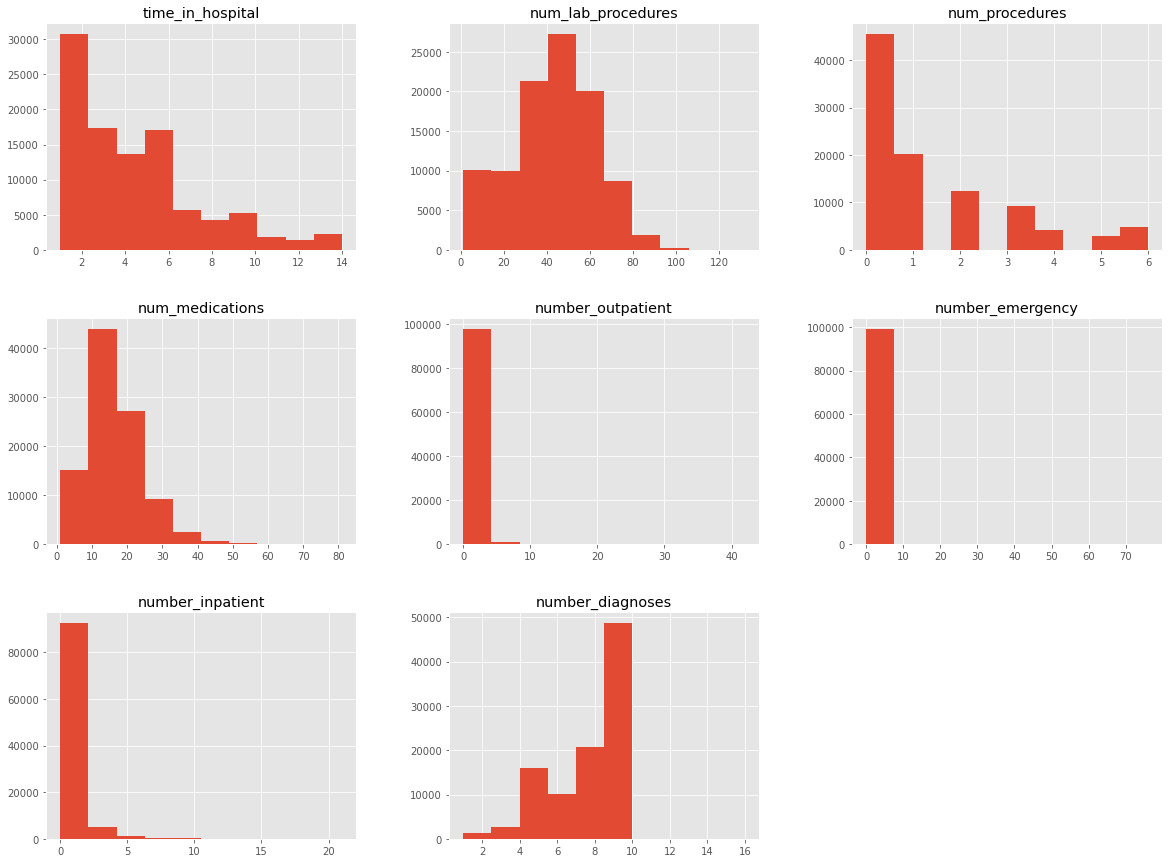

In [17]:
df.select_dtypes(include=['int64']).hist(figsize=(20,15))
plt.show()

About categorical attributes

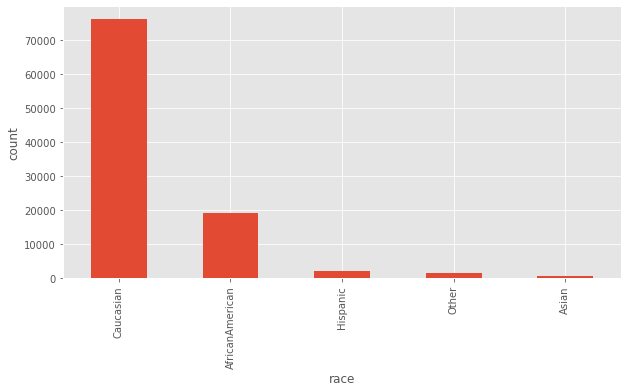

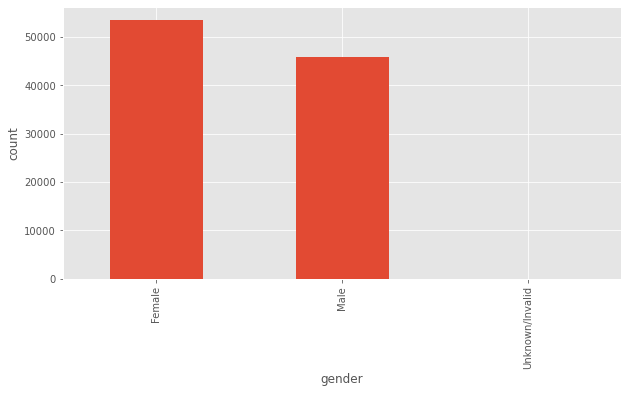

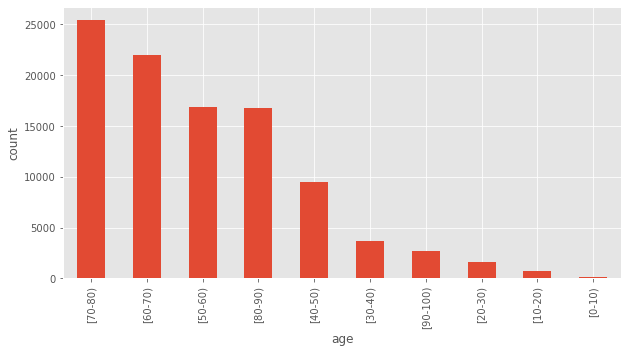

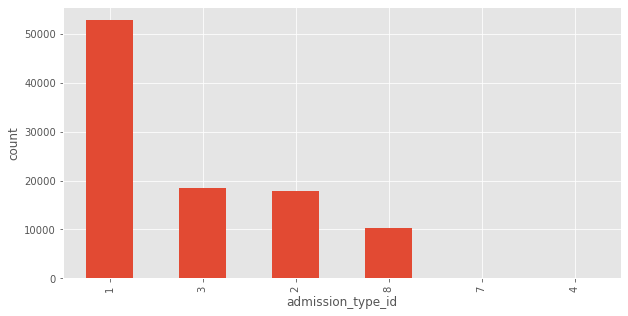

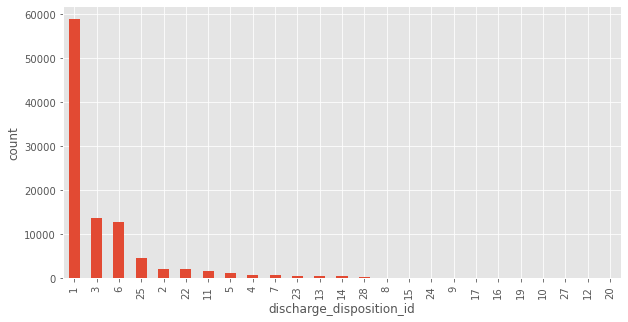

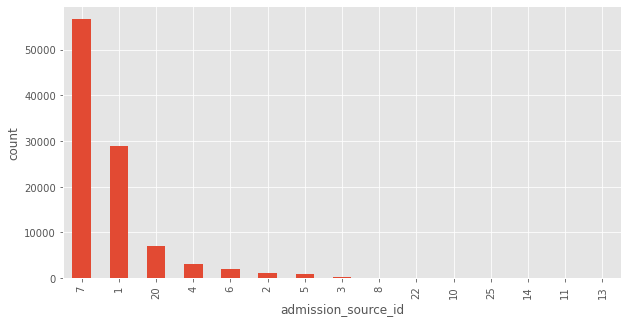

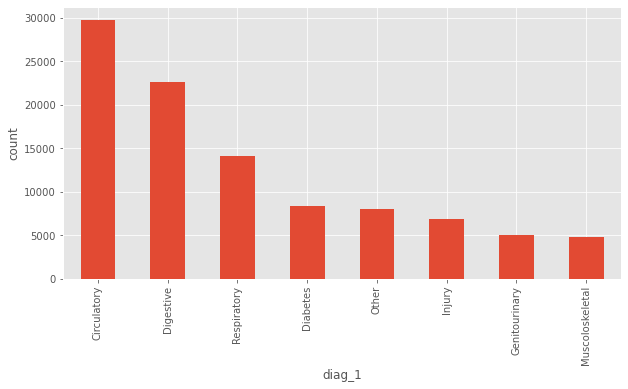

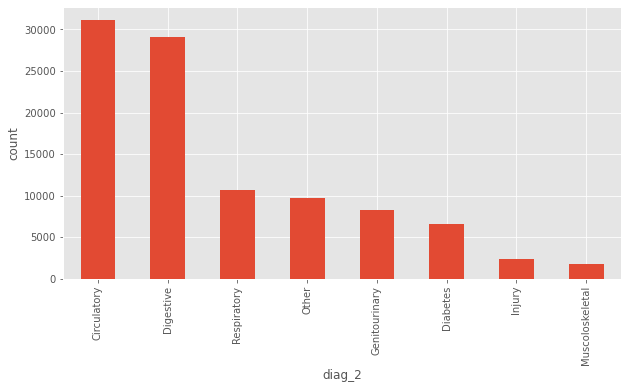

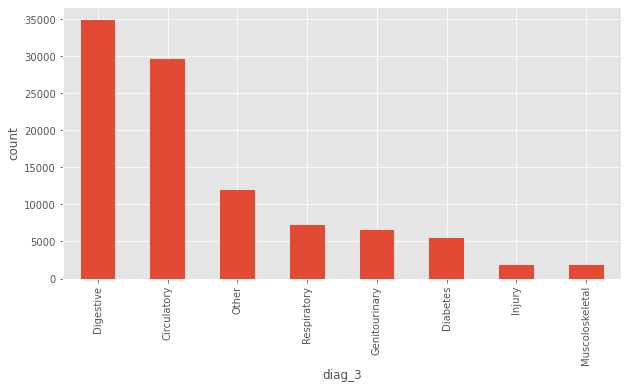

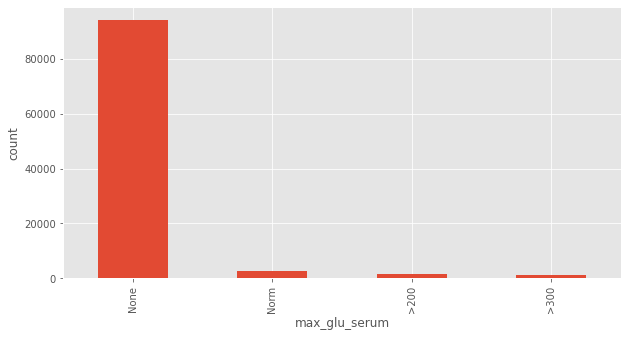

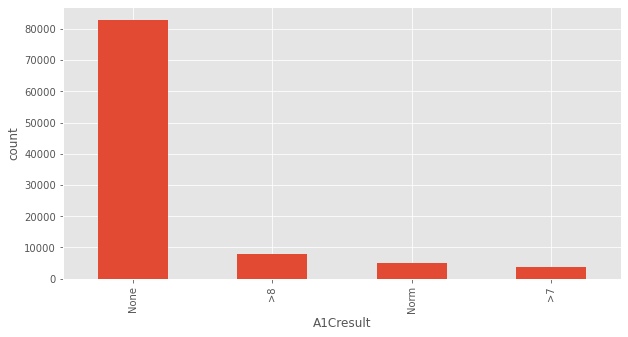

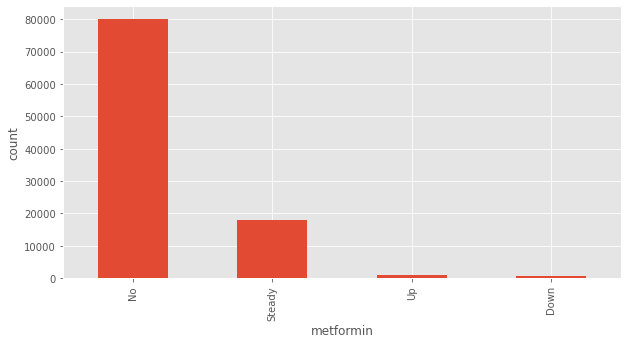

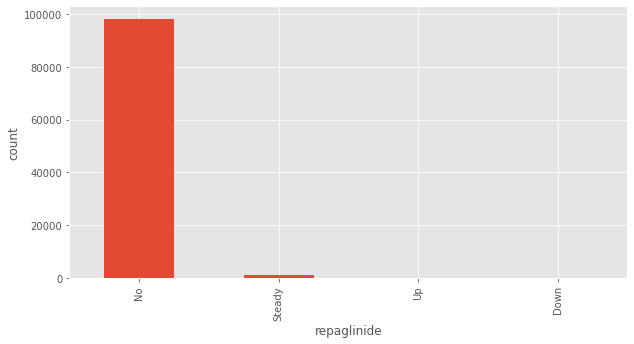

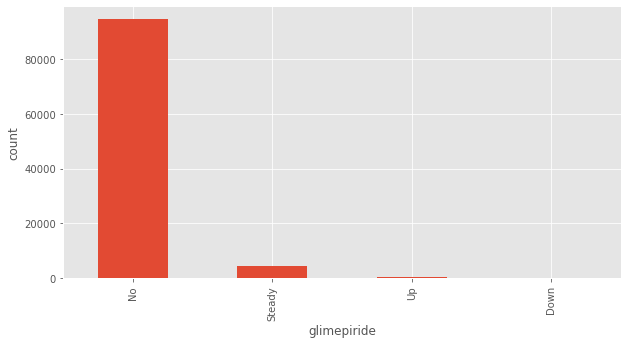

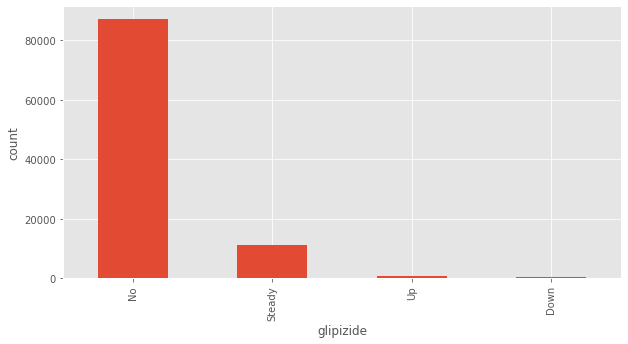

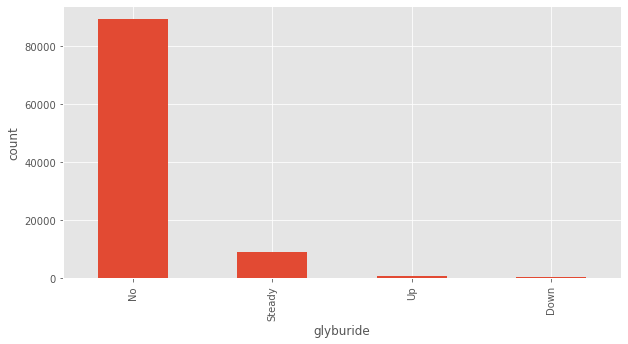

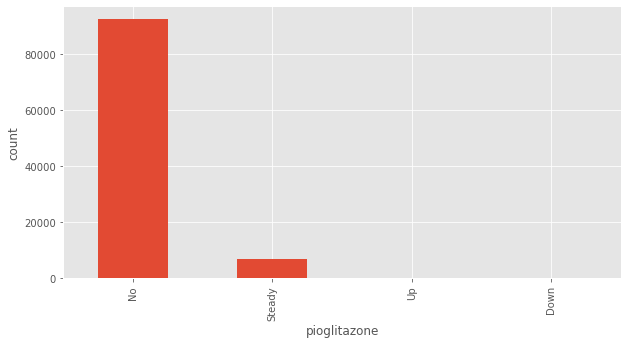

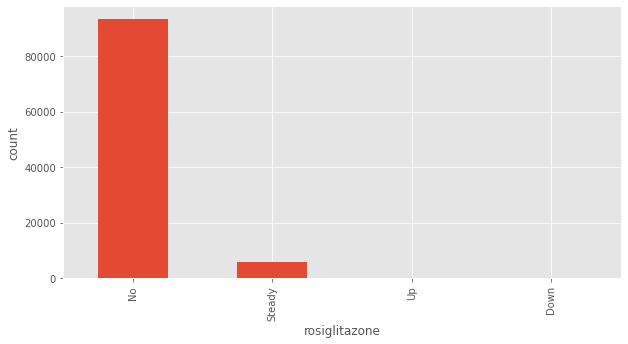

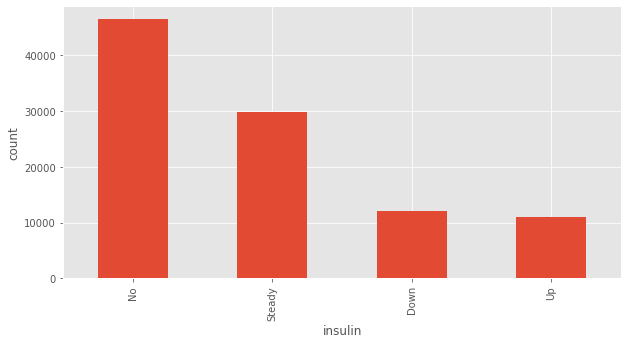

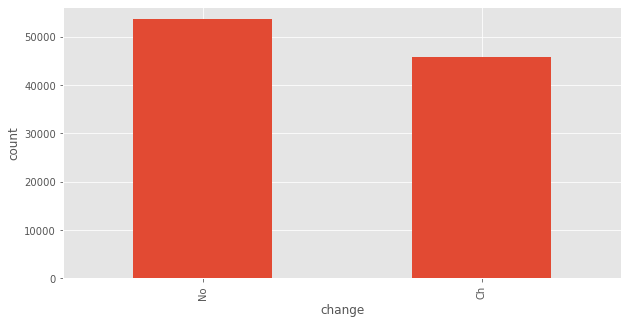

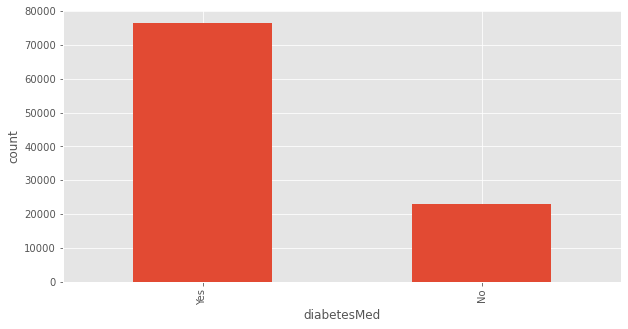

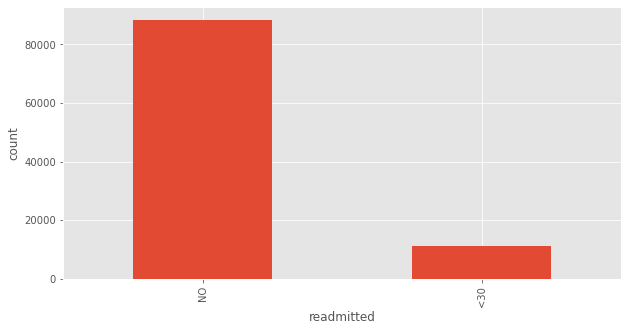

In [18]:
categorical_attr = df.select_dtypes(include=['category']).columns.to_list()
for attribute in categorical_attr:
    val = df[attribute].value_counts()
    val.plot(kind='bar', figsize=(10,5))
    plt.ylabel('count')
    plt.xlabel(attribute)
    plt.show()

How the numerical feature are correlated with the class labels

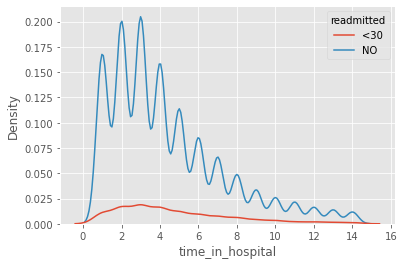

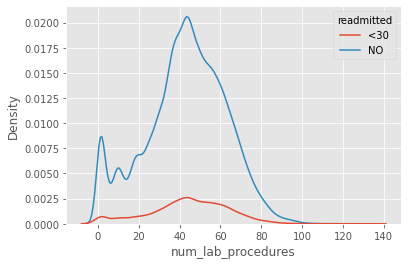

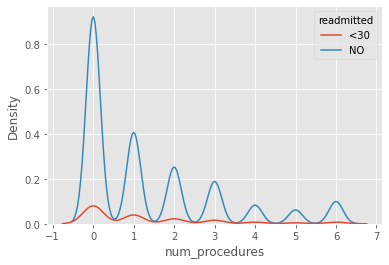

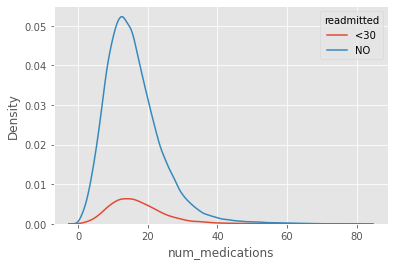

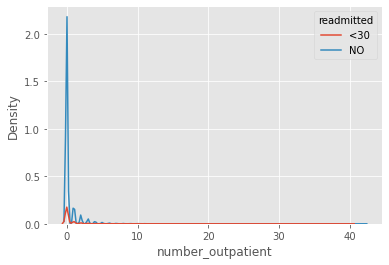

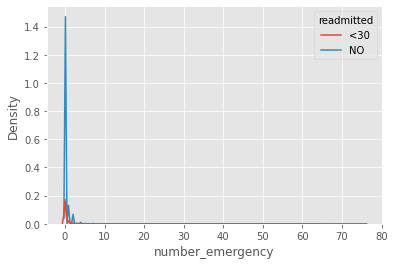

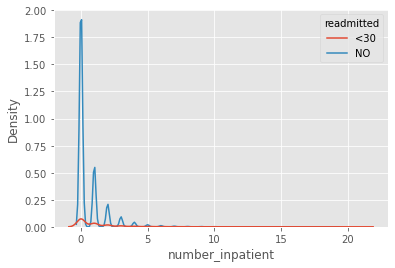

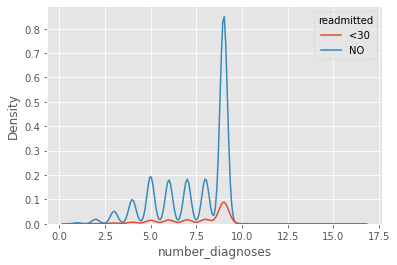

In [19]:
numericAttribute = df.select_dtypes(include=['int64']).columns.to_list()
numericAttribute.append('readmitted')

for attribute in numericAttribute:
    if attribute != 'readmitted':
        sb.kdeplot(x= df[attribute], hue= 'readmitted', data=df[numericAttribute])
        plt.show()


How the categorical feature are correlated with the class labels

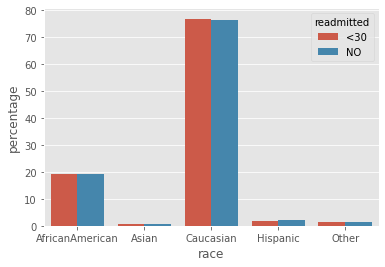

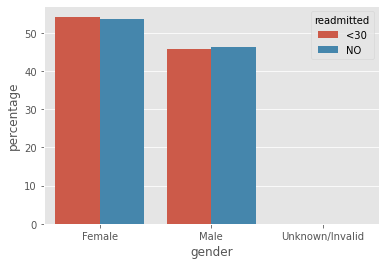

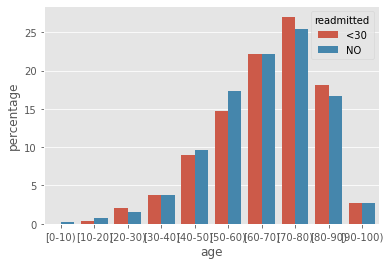

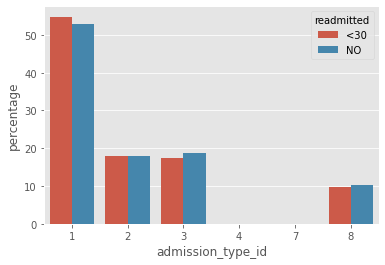

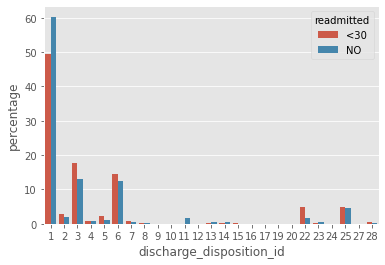

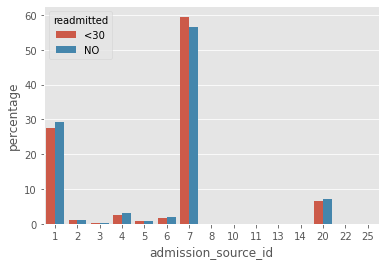

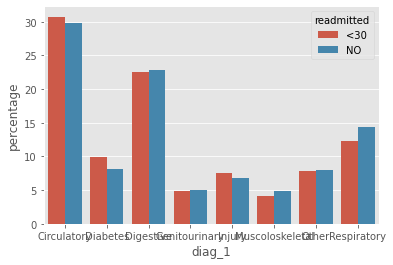

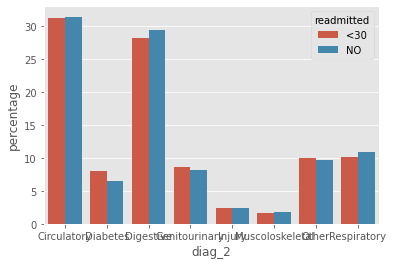

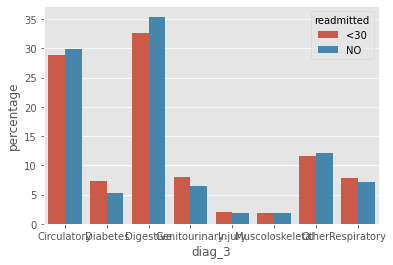

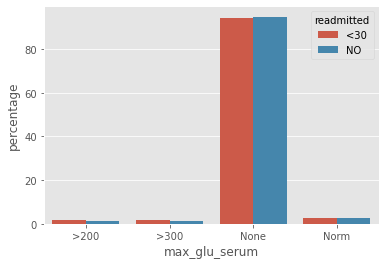

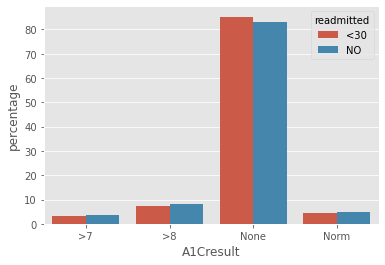

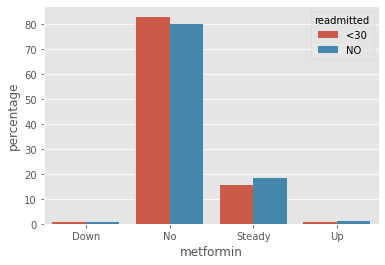

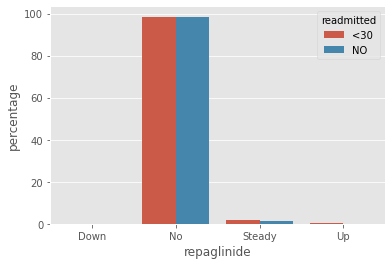

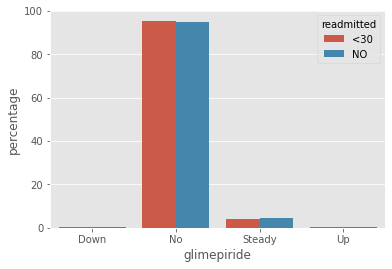

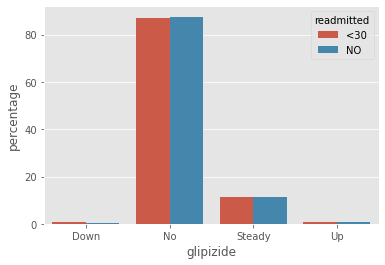

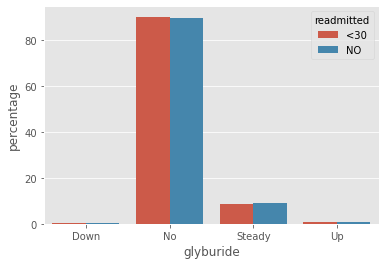

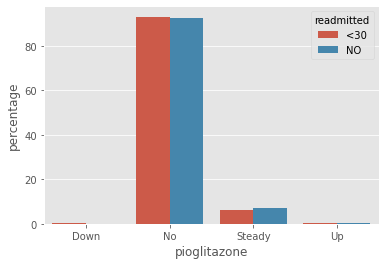

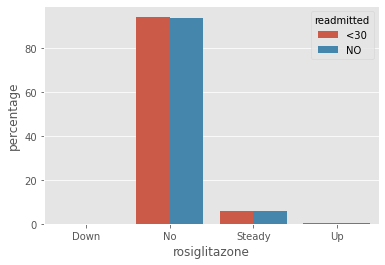

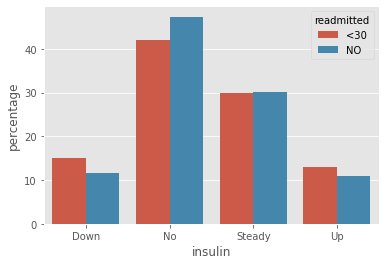

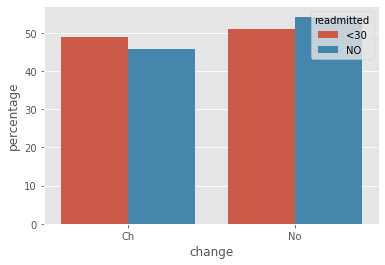

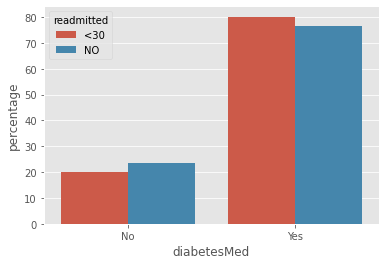

In [20]:
categoricalAttributes = df.select_dtypes(include=['category']).columns.to_list()
categoricalAttributes.append('readmitted')

for attribute in categoricalAttributes:
    if attribute != 'readmitted':
        attributeCounts = (df.groupby(['readmitted'])[attribute]
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values(attribute))
        p = sb.barplot(x=attribute, y="percentage", hue="readmitted", data=attributeCounts)
        plt.show()

Check the outliers

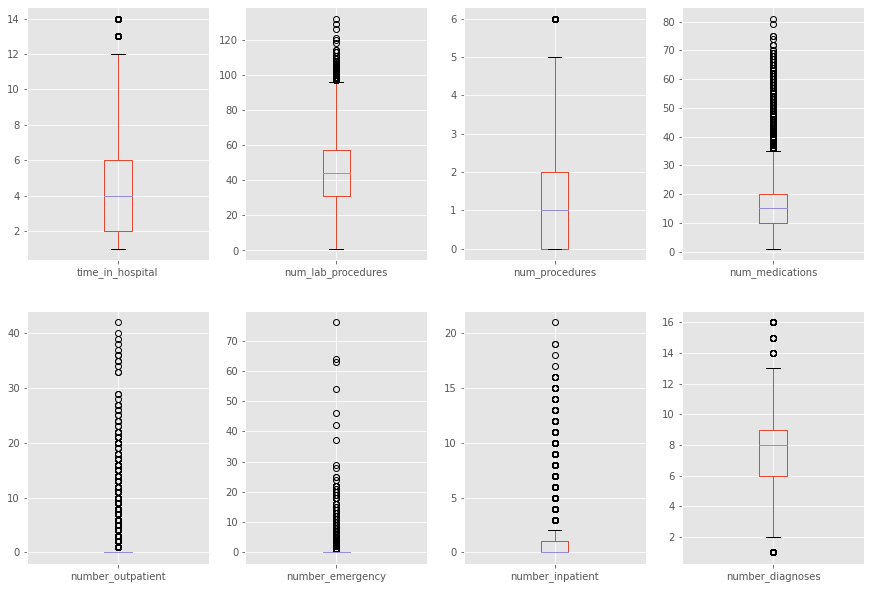

In [21]:
df.select_dtypes(include=['int64']).plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(15, 27), layout=(5, 4))
plt.show()

Binarization

In [22]:
cat_attributes = list(df.select_dtypes(include = ['category']).columns)
cat_attributes.remove('readmitted')
#cat_attributes.remove('diag_1')
#cat_attributes.remove('diag_2')
#cat_attributes.remove('diag_3')
df2 = pd.get_dummies(df, columns = cat_attributes)
new_attr_list = list(df2.columns)
#new_attr_list.remove('diag_1')
#new_attr_list.remove('diag_2')
#new_attr_list.remove('diag_3')
new_attr_list.remove('readmitted')
df2 = df2[new_attr_list]

In [23]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import KFold, cross_val_score
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

#x_train, x_test, y_train, y_test = train_test_split(df2[new_attr_list], df['readmitted'], test_size=0.4, random_state=0)
x = np.array(df2.values)
y = np.array(df['readmitted'].values)
# define oversampling strategy

seed = 121
test_size = .2

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=seed)
# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
x_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(x_train, y_train)

models = []
models.append(('KneiboarsClassifier', KNeighborsClassifier(3)))
models.append(('C45', DecisionTreeClassifier(criterion='entropy')))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier( splitter="random", random_state=1, max_depth=5, max_leaf_nodes=15)))
models.append(('RandomForestClassifier', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=24)))
#models.append(('MLPClassifier',MLPClassifier(alpha=1, max_iter=1000)))
models.append(('AdaBoostClassifier',  AdaBoostClassifier()))
models.append(('GaussianNaiveBayes', GaussianNB()))
#models.append(('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()))
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed, shuffle = True)
    cv_results = cross_val_score(model, x_train_SMOTE, y_train_SMOTE, cv=kfold, scoring='accuracy')
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ModuleNotFoundError: No module named 'imblearn'

### **Evaluation**

##### **Do predictions on test set**

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [23]:
model = KNeighborsClassifier(3)
model.fit(x_train_SMOTE, y_train_SMOTE)
predictions = model.predict(x_test)


In [24]:
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

Accuracy: 0.70


In [25]:
def make_confusion_matrix(cf, categories='auto', cbar=True, cmap='Blues', title=None):
    group_counts = [f'{value}\n' for value in cf.flatten()]

    box_labels = [f'{v1}'.strip() for v1 in group_counts]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    sb.heatmap(cf, annot=box_labels, fmt='', cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if title:
        plt.title(title)

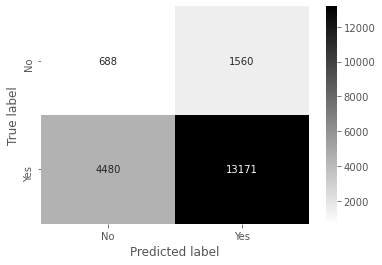

In [26]:
categories = ['No', 'Yes']
make_confusion_matrix(confusion_matrix(y_test, predictions), categories=categories, cmap='binary')

In [27]:
print('Classification report')
print(classification_report(y_test, predictions))


Classification report
              precision    recall  f1-score   support

         <30       0.13      0.31      0.19      2248
          NO       0.89      0.75      0.81     17651

    accuracy                           0.70     19899
   macro avg       0.51      0.53      0.50     19899
weighted avg       0.81      0.70      0.74     19899



In [28]:
##### **Compute the Roc Curve for each class**

In [29]:
from sklearn.metrics import roc_curve, auc

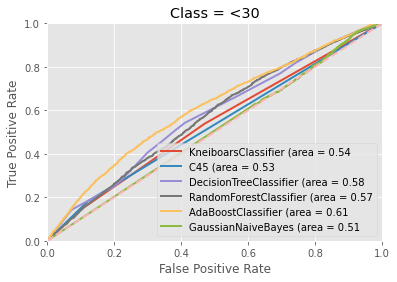

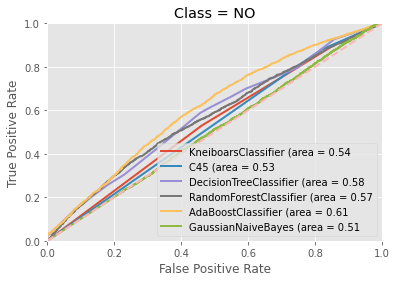

In [30]:
one_hot_encoding = np.array(pd.get_dummies(y_test, columns = ['readmitted']))


probs = []

for  _,model in models:
    model.fit(x_train_SMOTE, y_train_SMOTE)
    probs.append(model.predict_proba(x_test))
    
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(np.unique(y))):
    plt.figure()
    m = 0

    for name, _ in models:
        fpr[i], tpr[i], _ = roc_curve(one_hot_encoding[:, i], probs[m][:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[i], tpr[i], lw=2, label=name + f' (area = {roc_auc[i]:.2f}')
        m += 1

    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class = ' + str(np.unique(y)[i]))
    plt.legend(loc='lower right')

    plt.show()  